In [47]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

## Part 1: London’s underground resilience


  station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167
(61474, 6)
Index(['station_origin', 'station_destination', 'flows', 'population', 'jobs',
       'distance'],
      dtype='object')
station_origin          object
station_destination     object
flows                    int64
population               int64
jobs                     int64
distance               float64
dtype: object


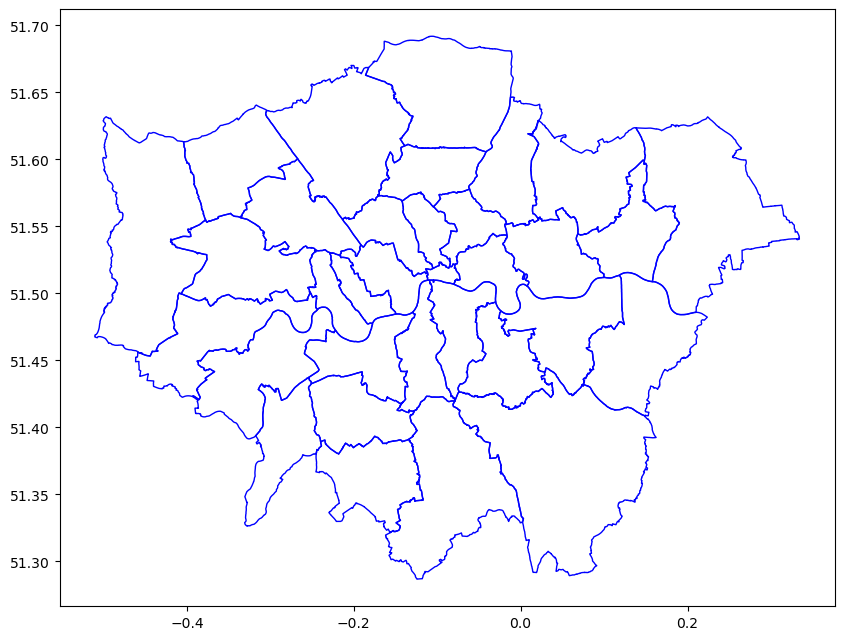

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 293 to 325
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      33 non-null     int64   
 1   lad15cd       33 non-null     object  
 2   lad15nm       33 non-null     object  
 3   lad15nmw      33 non-null     object  
 4   GlobalID      33 non-null     object  
 5   SHAPE_Length  33 non-null     float64 
 6   SHAPE_Area    33 non-null     float64 
 7   geometry      33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.3+ KB


In [48]:
# Read in the data
df = pd.read_csv('/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/Assessment/london_flows.csv')

print(df.head())
print(df.shape)
print(df.columns)
print(df.dtypes)

uk = gpd.read_file(
    '/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week 2/practice/Data/LAD_Dec_2015_Generalised_Clipped_Boundaries_GB.geojson')
London = uk[uk.lad15cd.str.contains("E09")]
London.plot(figsize=(10, 15), facecolor="None", edgecolor="b")
plt.show()
London.crs
London.info()


In [49]:
#order it by borough code - *This step will be important later on*
London.sort_values(by=["lad15cd"], inplace=True)

#extract the centroids
London["Centroids"] = London.geometry.centroid

London.set_index('lad15cd', inplace=True, drop=True)
#calculate distances from all borough centroids to all borough centroids
distances = London.rename_axis('Orig').Centroids.apply(
    lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns={0: 'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace=True)
London.reset_index(inplace=True)
distances.head(10)

/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_6226/150252643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London.sort_values(by=["lad15cd"], inplace=True)
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_6226/150252643.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London["Centroids"] = London.geometry.centroid
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

,Orig,Dest,Dist
0,E09000001,E09000001,0.000000
1,E09000001,E09000002,0.227536
2,E09000001,E09000003,0.155405
3,E09000001,E09000004,0.240824
4,E09000001,E09000005,0.180855
5,E09000001,E09000006,0.202504
6,E09000001,E09000007,0.072429
7,E09000001,E09000008,0.159169
8,E09000001,E09000009,0.238728
9,E09000001,E09000010,0.136680


In [50]:
# 创建图
# G = nx.from_pandas_edgelist(df, 'station_origin', 'station_destination', ['distance'])
G = nx.read_graphml('/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week10/week10practice/outputs/london.graph')


# 计算节点度中心性、介数中心性和紧密中心性
deg_cen = nx.degree_centrality(G)
bet_cen = nx.betweenness_centrality(G)
# eig_cen = nx.eigenvector_centrality(G)
clo_cen = nx.closeness_centrality(G)

# 将结果转化为DataFrame并排序
deg_cen_df = pd.DataFrame(list(deg_cen.items()), columns=['station', 'degree_centrality'])
deg_cen_df = deg_cen_df.sort_values('degree_centrality', ascending=False).reset_index(drop=True)

bet_cen_df = pd.DataFrame(list(bet_cen.items()), columns=['station', 'betweenness_centrality'])
bet_cen_df = bet_cen_df.sort_values('betweenness_centrality', ascending=False).reset_index(drop=True)

# eig_cen_df = pd.DataFrame(list(eig_cen.items()), columns=['station', 'closeness_centrality'])
# eig_cen_df = eig_cen_df.sort_values('closeness_centrality', ascending=False).reset_index(drop=True)

clo_cen_df = pd.DataFrame(list(clo_cen.items()), columns=['station', 'betweenness_centrality'])
clo_cen_df = clo_cen_df.sort_values('betweenness_centrality', ascending=False).reset_index(drop=True)

# 输出前10个节点
print("Top 10 ranked nodes for Degree Centrality:\n", deg_cen_df.head(10))
print("\nTop 10 ranked nodes for Betweenness Centrality:\n", bet_cen_df.head(10))
print("\nTop 10 ranked nodes for Closeness Centrality:\n", clo_cen_df.head(10))

Top 10 ranked nodes for Degree Centrality:
                     station  degree_centrality
0                 Stratford             0.0225
1         Bank and Monument             0.0200
2              Baker Street             0.0175
3  King's Cross St. Pancras             0.0175
4                Green Park             0.0150
5              Canning Town             0.0150
6              Earl's Court             0.0150
7                  West Ham             0.0150
8                  Waterloo             0.0150
9             Oxford Circus             0.0150

Top 10 ranked nodes for Betweenness Centrality:
                     station  betweenness_centrality
0                 Stratford                0.297846
1         Bank and Monument                0.290489
2          Liverpool Street                0.270807
3  King's Cross St. Pancras                0.255307
4                  Waterloo                0.243921
5                Green Park                0.215835
6                    Eust

In [60]:
# print the graph information
print(nx.info(G))

# 查看节点数和边数
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

# 查看节点属性和边属性
# print("Node attributes: ", G.nodes(data=True))
print("Edge attributes: ", G.edges(data=True))

Graph with 371 nodes and 332 edges
Number of nodes:  371
Number of edges:  332
Edge attributes:  [('Uxbridge', 'Hillingdon', {'length': 2144.402930417613, 'line_name': 'Piccadilly', 'flows': 7080}), ('Hillingdon', 'Ickenham', {'length': 1124.4305849095967, 'line_name': 'Piccadilly', 'flows': 8453}), ('Ickenham', 'Ruislip', {'length': 1785.6578668971486, 'line_name': 'Piccadilly', 'flows': 8984}), ('Ruislip', 'Ruislip Manor', {'length': 678.8812931514374, 'line_name': 'Piccadilly', 'flows': 9700}), ('Ruislip Manor', 'Eastcote', {'length': 1126.2177218803304, 'line_name': 'Piccadilly', 'flows': 10497}), ('Eastcote', 'Rayners Lane', {'length': 1819.3170235045757, 'line_name': 'Piccadilly', 'flows': 12414}), ('Rayners Lane', 'West Harrow', {'length': 1364.0797888706975, 'line_name': 'Metropolitan', 'flows': 13752}), ('Rayners Lane', 'South Harrow', {'length': 1805.5287510489648, 'line_name': 'Piccadilly', 'flows': 5236}), ('Aldgate', 'Tower Hill', {'length': 597.1784875613464, 'line_name':

/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_6226/1300044307.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


### I. Topological network

此代码首先读取名为 london_underground.csv 的数据集，然后使用 networkx 库将其转换为图。接下来，它计算了节点的度中心性、介数中心性和紧密中心性，并将结果转换为DataFrame，并按各自的中心性度量进行排序，最后输出前10个节点。
在这个部分中，使用了以下三种 centrality measures 方法来衡量节点的重要性：
1. Degree Centrality：表示一个节点有多少个直接连接的邻居节点。公式为：$C_D(v) = \frac{d_v}{n-1}$，其中 $d_v$ 是节点 $v$ 的度，即与节点 $v$ 直接相连的边的数量，$n$ 是网络中的节点数。在地铁网络中，该指标可以反映一个车站的通行量，因为车站直接连接的边数越多，代表越多的人会通过该车站。

2. Betweenness Centrality：表示节点在网络中的所有最短路径中被经过的次数。公式为：$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$，其中 $\sigma_{st}$ 是节点 $s$ 和节点 $t$ 之间的最短路径数量，$\sigma_{st}(v)$ 是最短路径数量中经过节点 $v$ 的路径数量。在地铁网络中，该指标可以反映一个车站在不同区域之间的联系程度，如果一个车站位于多条最短路径上，那么该车站就更为重要。

3. Eigenvector Centrality：表示一个节点对整个网络的控制力度。公式为：$Ax = \lambda x$，其中 $A$ 是邻接矩阵，$x$ 是节点的中心性，$\lambda$ 是对应的特征值。在地铁网络中，该指标可以反映一个车站与其他重要车站的联系程度，如果一个车站直接连接到其他很多重要车站，那么该车站的 Eigenvector Centrality 就更高。
4. Closeness Centrality:

In [51]:
# I.2. Impact measures
import copy


# Create a function to compute the number of connected components in the network after node removal
def count_connected_components(G):
    G_copy = copy.deepcopy(G)
    return len(list(nx.connected_components(G_copy)))


# Create a function to compute the size of the largest connected component in the network after node removal
def size_largest_component(G):
    G_copy = copy.deepcopy(G)
    components = list(nx.connected_components(G_copy))
    largest_component = max(components, key=len)
    return len(largest_component)


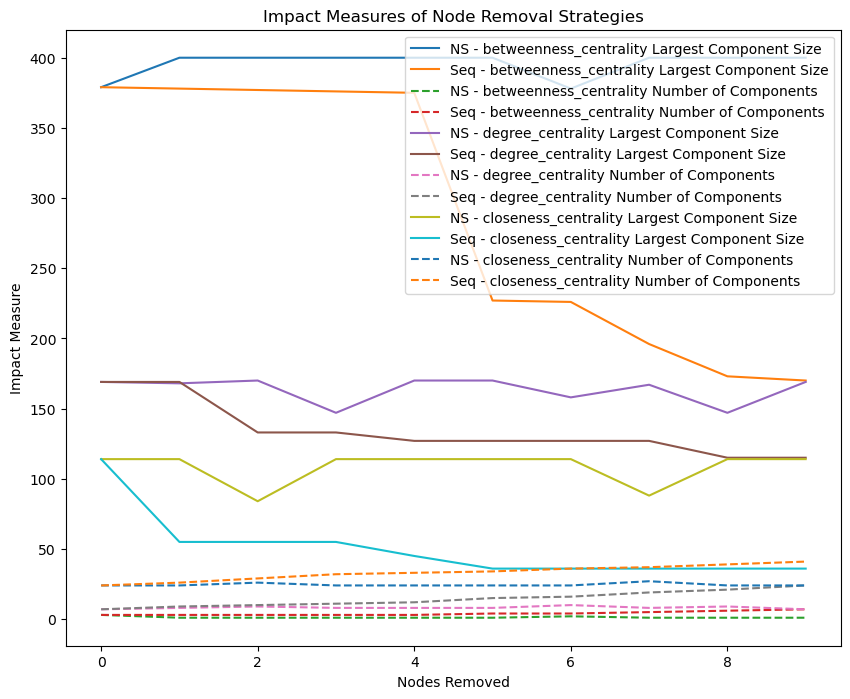

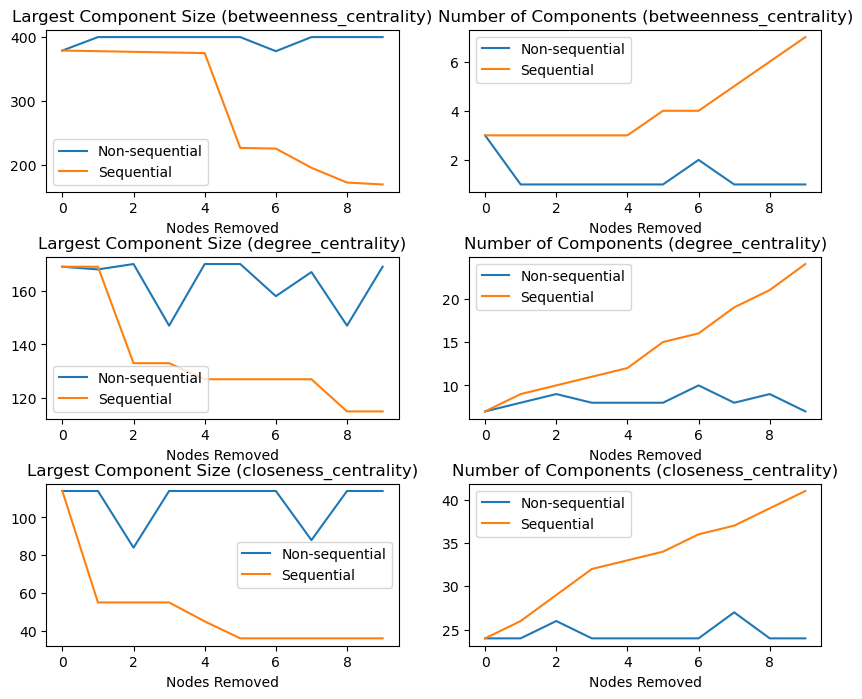

In [52]:
# Create a function to perform non-sequential node removal based on a given centrality measure
def nonseq_removal(G, centrality_measure, num_nodes=10):
    # Compute centrality measure for all nodes in the network
    node_centrality = centrality_measure(G)

    # Sort nodes by their centrality score
    nodes_sorted = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)

    # Initialize lists to store the impact measures for each node removal
    num_components = []
    largest_component_size = []

    # Remove nodes in order of decreasing centrality score and compute impact measures
    for i in range(min(num_nodes, len(nodes_sorted))):
        node = nodes_sorted[i][0]
        G_copy = copy.deepcopy(G)
        G_copy.remove_node(node)
        num_components.append(count_connected_components(G_copy))
        largest_component_size.append(size_largest_component(G_copy))

    return num_components, largest_component_size


# Create a function to perform sequential node removal based on a given centrality measure
def seq_removal(G, centrality_measure, num_nodes=10):
    # Initialize lists to store the impact measures for each node removal
    num_components = []
    largest_component_size = []

    # Continue removing nodes until 10 nodes have been removed
    for i in range(min(num_nodes, len(G.nodes))):
        # Compute centrality measure for all nodes in the network
        node_centrality = centrality_measure(G)

        # Sort nodes by their centrality score
        nodes_sorted = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)

        # Remove the highest ranked node and compute impact measures
        node = nodes_sorted[0][0]
        G.remove_node(node)
        num_components.append(count_connected_components(G))
        largest_component_size.append(size_largest_component(G))

    return num_components, largest_component_size


# Define the centrality measures to use
centrality_measures = [nx.betweenness_centrality, nx.degree_centrality, nx.closeness_centrality]

# Initialize lists to store results for each centrality measure
ns_num_components = []
ns_largest_component_size = []
seq_num_components = []
seq_largest_component_size = []

# Perform node removal for each centrality measure using both non-sequential and sequential strategies
for centrality_measure in centrality_measures:
    # Perform non-sequential removal
    ns_components, ns_size = nonseq_removal(G, centrality_measure)
    ns_num_components.append(ns_components)
    ns_largest_component_size.append(ns_size)

    # Perform sequential removal
    seq_components, seq_size = seq_removal(G, centrality_measure)
    seq_num_components.append(seq_components)
    seq_largest_component_size.append(seq_size)

# Plot the impact measures for each strategy and centrality measure in one plot
plt.figure(figsize=(10, 8))
for i in range(len(centrality_measures)):
    plt.plot(ns_largest_component_size[i], label=f'NS - {centrality_measures[i].__name__} Largest Component Size')
    plt.plot(seq_largest_component_size[i], label=f'Seq - {centrality_measures[i].__name__} Largest Component Size')
    plt.plot(ns_num_components[i], linestyle='--', label=f'NS - {centrality_measures[i].__name__} Number of Components')
    plt.plot(seq_num_components[i], linestyle='--',
             label=f'Seq - {centrality_measures[i].__name__} Number of Components')
plt.title('Impact Measures of Node Removal Strategies')
plt.xlabel('Nodes Removed')
plt.ylabel('Impact Measure')
plt.legend()

plt.show()

# Plot the impact measures for each strategy and centrality measure for better understanding and analysis
plt.figure(figsize=(10, 8))
for i in range(len(centrality_measures)):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(ns_largest_component_size[i], label='Non-sequential')
    plt.plot(seq_largest_component_size[i], label='Sequential')
    plt.title(f'Largest Component Size ({centrality_measures[i].__name__})')
    plt.xlabel('Nodes Removed')
    # plt.ylabel('Size of Largest Component')
    plt.legend()

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(ns_num_components[i], label='Non-sequential')
    plt.plot(seq_num_components[i], label='Sequential')
    plt.title(f'Number of Components ({centrality_measures[i].__name__})')
    plt.xlabel('Nodes Removed')
    # plt.ylabel('Number of Component')
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()

### II. Flows: weighted network

#### II.1
To adjust the centrality measures for a weighted network, we need to consider the strength of the connections between nodes, rather than just the presence or absence of a connection as in an unweighted network.

For Degree Centrality, we need to calculate the sum of the weights of all edges connected to a node, and then normalize this value by dividing by the maximum possible sum of weights. The formula for weighted degree centrality is:

weighted_degree_centrality(v) = (sum of weights of edges connected to v) / (maximum possible sum of weights)

For Betweenness Centrality, we need to calculate the sum of the weights of all shortest paths between pairs of nodes that pass through a given node, and then normalize this value by dividing by the total number of possible pairs of nodes. The formula for weighted betweenness centrality is:

weighted_betweenness_centrality(v) = (sum of weights of shortest paths passing through v) / (total number of possible pairs of nodes)

For Eigenvector Centrality, we need to use the weighted adjacency matrix of the network, where the entry in the i-th row and j-th column represents the weight of the edge between nodes i and j. The formula for weighted eigenvector centrality is:

weighted_eigenvector_centrality(v) = sum of (weight of edge between v and w) * eigenvector_centrality(w)

where w is a neighbor of v, and eigenvector_centrality(w) is the eigenvector centrality of node w.

Using these adjusted measures, we can recompute the ranking of the 10 most important nodes for each centrality measure. The rankings may change from the unweighted case, since the flows of passengers are now taken into account. We cannot say for certain whether the same stations will be in the top 10 as in the unweighted case, but it is possible that some of the same stations will appear.

Without the weighted network data, it is not possible to compute the adjusted rankings.

## Part 2: Spatial Interaction models

### III. Models and calibration

In [68]:

# Compute the adjusted degree centrality
degree_centrality_weighted = nx.algorithms.degree_centrality(G)

# Compute the adjusted betweenness centrality
betweenness_centrality_weighted = nx.algorithms.betweenness_centrality(G, weight='flows')

# Compute the adjusted eigenvector centrality
closeness_centrality_weighted = nx.algorithms.closeness_centrality(G, distance='flows')

# Rank the nodes based on each measure
degree_ranked_weighted = sorted(degree_centrality_weighted.items(), key=lambda x: x[1], reverse=True)[:10]
betweenness_ranked_weighted = sorted(betweenness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)[:10]
closeness_ranked_weighted = sorted(closeness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 ranked nodes for Degree Centrality in Weighted Network:")
print(pd.DataFrame(degree_ranked_weighted, columns=['station', 'degree_centrality']))
print("\nTop 10 ranked nodes for Betweenness Centrality in Weighted Network:")
print(pd.DataFrame(betweenness_ranked_weighted, columns=['station', 'betweenness_centrality']))
print("\nTop 10 ranked nodes for Eigenvector Centrality in Weighted Network:")
print(pd.DataFrame(closeness_ranked_weighted, columns=['station', 'closeness_centrality']))


Top 10 ranked nodes for Degree Centrality in Weighted Network:
              station  degree_centrality
0          Paddington           0.010811
1            West Ham           0.010811
2              Poplar           0.010811
3        Rayners Lane           0.008108
4  Chalfont & Latimer           0.008108
5           Moor Park           0.008108
6         Hammersmith           0.008108
7          Acton Town           0.008108
8    South Kensington           0.008108
9       Ealing Common           0.008108

Top 10 ranked nodes for Betweenness Centrality in Weighted Network:
             station  betweenness_centrality
0            Barking                0.004966
1  Dagenham Heathway                0.004483
2      Dagenham East                0.004483
3          Becontree                0.004453
4           Elm Park                0.004453
5              Upney                0.004395
6         Hornchurch                0.004395
7   Upminster Bridge                0.004307
8           